In [1]:
# !pip install keras cython h5py

In [2]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Using TensorFlow backend.


## Explore the Data

Today, we'll use deep learning to solve MNIST, the hand-written digit classification task. First, we'll use a multi-layer perceptron to accomplish this task, and then we'll use a convolutional neural network.

First, let's import and explore the data.

In [3]:
from keras.datasets import mnist

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


The data comprises grayscale images of hand-written digits. Let's visualize some.

In [5]:
X_train.shape

(60000, 28, 28)

target:  [0 4 1 9 2 1 3 1 4]


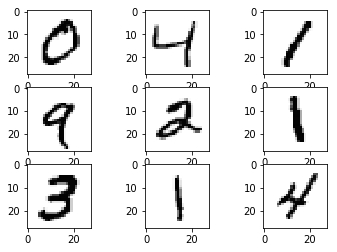

In [6]:
print('target: ', y_train[1:10])
fig = plt.figure(33)
for i in range(1,10):
    fig.add_subplot(330+i)
    plt.imshow(X_train[i], cmap='Greys')
    
# 2 tensors images, black and white

The shape of the data is 28x28, and the type is `numpy.unit8`, as demonstrated below. All images are the same shape.

In [7]:
X_train[0].shape

(28, 28)

In [8]:
type(X_train[0][0][0])

numpy.uint8

In [9]:
set([i.shape for i in X_train])

{(28, 28)}

## Preproces the data

Normalize the data. Pixel values of images are bwtween 0 and 255, and we'd like them to be floats between 0 and 1.

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [8]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

We need to one-hot encode our Ys. Luckily, Keras has a utility to do this for us!

In [9]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [10]:
y_train[:3]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

Generally, images are described as height, width, num_channels. Some deep learning languages (i.e. Theano) use num_channels, height, width. We need to see how to format our images!

In [11]:
keras.backend.image_data_format()

'channels_last'

In [12]:
X_train.shape

(60000, 28, 28)

To explicitly say there's 1 channel, we need to add a 1 to the shape.

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [14]:
X_train.shape

(60000, 28, 28, 1)

In [15]:
y_train.shape

(60000, 10)

In [16]:
X_test.shape

(10000, 28, 28, 1)

In [17]:
y_test.shape

(10000, 10)

In [18]:
X_train[0].shape

(28, 28, 1)

## The Multi-Layer Perceptron Model

Before we get into CNNs, we will first build a multi-layer perceptron (MLP). This involves an input layer, a layer to flatten the data, and an output layer.

To build it, we will use the **sequential model**. Here, we can **add** layers in a sequential list, **compile** the model with an optimizer, loss function, and scorint metric, then **fit** the model to the data. 

First, let's inport some layers and the sequential model.

In [19]:
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Activation, Dense, Flatten
from keras.models import Sequential
from keras.activations import relu, softmax

Now, let's instantiate our model. Notice that the first layer has an `input_shape` parameter. Because there are 24 output neurons, and 28 inputs to that 'neurons', the output of that layer is 28x28x24. 

The next layer, `flatten`, simply turns the 3d input into a vector of length 18816 (18816 = 28x28x24). 

Finally, we have a `dense` layer with an output shape of 10 neurons and a `softmax` activation. This results in 10 output neurons that encode probabilities of each class (digits 0-9).

In [39]:
mlp = Sequential([
    Dense(24, input_shape=(28,28,1), activation='relu', name='dense_1_mlp'),
    Flatten(name='flatten_1_mlp'),
    Dense(24, activation='relu', name='dense_2_mlp'),
    Dropout(.5),
    Dense(24, activation='relu', name='dense_3_mlp'),
    Dropout(.25),
    Dense(10, activation='softmax', name='digit_clf_mlp')
])

In [40]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_mlp (Dense)          (None, 28, 28, 24)        48        
_________________________________________________________________
flatten_1_mlp (Flatten)      (None, 18816)             0         
_________________________________________________________________
dense_2_mlp (Dense)          (None, 24)                451608    
_________________________________________________________________
dropout_11 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_3_mlp (Dense)          (None, 24)                600       
_________________________________________________________________
dropout_12 (Dropout)         (None, 24)                0         
_________________________________________________________________
digit_clf_mlp (Dense)        (None, 10)                250       
Total para

In [41]:
mlp.compile(optimizer=keras.optimizers.SGD(),
           loss=keras.losses.categorical_crossentropy,
           metrics=['accuracy'])

In [42]:
mlp_history = mlp.fit(X_train, y_train, validation_split=.2, epochs=5)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 21s 442us/step - loss: 1.3858 - acc: 0.5294 - val_loss: 0.4826 - val_acc: 0.8897
Epoch 2/5
48000/48000 [==============================] - 21s 442us/step - loss: 0.9028 - acc: 0.6951 - val_loss: 0.3723 - val_acc: 0.9073
Epoch 3/5
48000/48000 [==============================] - 21s 435us/step - loss: 0.8059 - acc: 0.7337 - val_loss: 0.3258 - val_acc: 0.9125
Epoch 4/5
48000/48000 [==============================] - 21s 437us/step - loss: 0.7611 - acc: 0.7462 - val_loss: 0.3130 - val_acc: 0.9186
Epoch 5/5
48000/48000 [==============================] - 21s 436us/step - loss: 0.7342 - acc: 0.7549 - val_loss: 0.2945 - val_acc: 0.9199


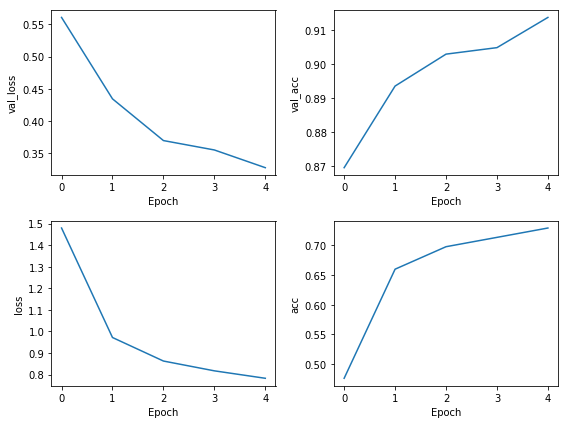

In [27]:
fig = plt.figure(figsize=(8,6))
for i, (title, data) in enumerate(mlp_history.history.items()):
    fig.add_subplot(2,2,1+i)
    plt.plot(data)
    plt.xlabel('Epoch')
    plt.ylabel(title)
plt.tight_layout()

## The Convolutional Neural Network (CNN)

Now let's build a CNN. You'll see that this not only trains faster, but gets better scores. 

We'll play around with cnn parameters to see how some tuning can improve our model's performance.

In [28]:
cnn = Sequential([
    Conv2D(16, kernel_size=(5, 5), strides=(2,2),
                 activation='relu',
                 input_shape=(28,28,1),
                 padding='same', name='conv1'),
    Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2'),
    Dropout(.25),
    MaxPool2D(name='convpool1'),
    Flatten(name='convflatten'),
    Dense(64, activation='relu', name='convdense1'),
    Dropout(.25),
    Dense(10, activation='softmax', name='convoutput')
])

In [29]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 16)        416       
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 16)        2320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
convpool1 (MaxPooling2D)     (None, 7, 7, 16)          0         
_________________________________________________________________
convflatten (Flatten)        (None, 784)               0         
_________________________________________________________________
convdense1 (Dense)           (None, 64)                50240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
__________

In [30]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [31]:
from keras.callbacks import TensorBoard, EarlyStopping

es = EarlyStopping(patience=0)
tb = TensorBoard(log_dir='./tf_logs/cnn/')

In [33]:
cnn_history = cnn.fit(X_train, y_train, validation_split=.3, epochs=5, callbacks=[tb, es])

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 36s 861us/step - loss: 0.0831 - acc: 0.9752 - val_loss: 0.0676 - val_acc: 0.9803
Epoch 2/5
42000/42000 [==============================] - 27s 655us/step - loss: 0.0772 - acc: 0.9766 - val_loss: 0.0655 - val_acc: 0.9808
Epoch 3/5
42000/42000 [==============================] - 27s 655us/step - loss: 0.0761 - acc: 0.9766 - val_loss: 0.0612 - val_acc: 0.9824
Epoch 4/5
42000/42000 [==============================] - 29s 681us/step - loss: 0.0702 - acc: 0.9778 - val_loss: 0.0596 - val_acc: 0.9825
Epoch 5/5
42000/42000 [==============================] - 28s 656us/step - loss: 0.0696 - acc: 0.9790 - val_loss: 0.0594 - val_acc: 0.9825


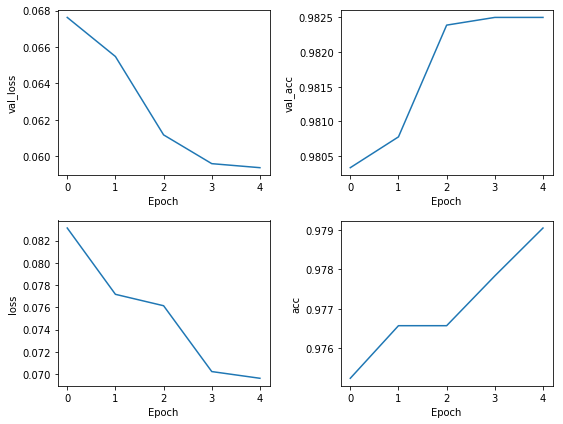

In [34]:
fig = plt.figure(figsize=(8,6))
for i, (title, data) in enumerate(cnn_history.history.items()):
    fig.add_subplot(2,2,1+i)
    plt.plot(data)
    plt.xlabel('Epoch')
    plt.ylabel(title)
plt.tight_layout()

In [35]:
loss, accuracy = cnn.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 159us/step


In [36]:
accuracy

0.98640000000000005

In [37]:
y_pred_probas = cnn.predict(X_test)

In [38]:
y_pred_probas[0]

array([  5.67540792e-10,   2.41034115e-07,   2.87700755e-06,
         4.37766812e-06,   4.52949500e-09,   5.72393999e-09,
         8.16915708e-14,   9.99991059e-01,   7.24616500e-09,
         1.40905024e-06], dtype=float32)

In [39]:
y_pred = np.argmax(y_pred_probas, axis=1)

In [40]:
y_pred[:5]

array([7, 2, 1, 0, 4])

In [41]:
np.argmax(y_test, axis=1)[:5]

array([7, 2, 1, 0, 4])

In [42]:
cnn.save('model.h5')

#### Which model has more params?

In [43]:
model = keras.models.load_model('model.h5')

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 16)        416       
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 16)        2320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
convpool1 (MaxPooling2D)     (None, 7, 7, 16)          0         
_________________________________________________________________
convflatten (Flatten)        (None, 784)               0         
_________________________________________________________________
convdense1 (Dense)           (None, 64)                50240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
__________